In [ ]:
!pip install statsmodels

In [17]:
!pip install -U imbalanced-learn

    100% |████████████████████████████████| 92kB 3.0MB/s ta 0:00:011
Requirement already up-to-date: scipy>=0.17.0 in /usr/local/lib/python3.5/dist-packages (from imbalanced-learn)
Requirement already up-to-date: numpy>=1.10.4 in /usr/local/lib/python3.5/dist-packages (from imbalanced-learn)
Requirement already up-to-date: scikit-learn>=0.17.1 in /usr/local/lib/python3.5/dist-packages (from imbalanced-learn)
  Running setup.py bdist_wheel for imbalanced-learn ... done
  Stored in directory: /root/.cache/pip/wheels/b8/20/bd/0b775f7e5d413ac72562b1a5126598bcb6e0eae10da659be9f
Successfully built imbalanced-learn


# Report

In [2]:
from IPython.display import IFrame
IFrame("report.pdf", width=1000, height=600)

# Problem: The two key questions we would like you to investigate are:
•	What are the key features behind purchasing a vehicle?

•	How large an influence is the price on customer’s purchasing behaviour?


# Typical outputs could include:
•	Plots and tables detailing your exploration of the data

•	A basic statistical or machine learning model that can explain the data

•	A discussion of the 2 key questions

•	A plan for future work and how the insight gained could be actioned in a business scenario


# Required Libs.

In [ ]:
# %matplotlib inline

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import RandomOverSampler

Checking the number of features in data

In [3]:
!ls -l -h

total 131M
-rw-r--r-- 1 1000 1000 131M Mar 31 08:18 Sample Availability Data
-rw-r--r-- 1 1000 1000 531K Jul  5 11:12 Untitled.ipynb


In [2]:
!head -1 Sample\ Availability\ Data | tr '|' '\n' | wc -l

25


Some Important Features:

* v1 --> unique query id
* v2 --> unique vehicle id per query
* v3 --> query date
* v6 --> price of car
* v22 --> rental duration
* v23 --> pickup date
* v25 --> target (booked or not booked)

# Loading and reading data

In [3]:
fmt_names = "v{}"
names = [fmt_names.format(i + 1) for i in range(25)]

df_raw = pd.read_csv("Sample Availability Data", sep = "|", header = None, encoding = "utf-8", names=names)

In [4]:
display(df_raw.head())
display(df_raw.describe())
display(df_raw.dtypes)

v1          v2                   v3  v4  v5      v6  v7  \
0  102120401529162609  1001396153  2017-01-02 12:04:01   2   1  750.26   2   
1  102120401529162609   401793302  2017-01-02 12:04:01   2   1  322.12   4   
2  102120401529162609  2100312948  2017-01-02 12:04:01   1   1  466.38   1   
3  102120401529162609  1697088827  2017-01-02 12:04:01   1   1  303.52   4   
4  102120401529162609   682137395  2017-01-02 12:04:01   1   1  282.19   1   

   v8  v9  v10 ...   v16   v17  v18  v19  v20  v21   v22                  v23  \
0   1   1    5 ...   8.0   385    3    1    1    2  14.0  2017-02-04 00:00:00   
1   1   1    5 ...   6.0  1368    3    0    1    2  14.0  2017-02-04 00:00:00   
2   1   2    5 ...   7.0  1741    3    0    1    2  14.0  2017-02-04 00:00:00   
3   1   2    5 ...   6.0  1912    3    0    1    2  14.0  2017-02-04 00:00:00   
4   1   1    3 ...   6.0  1960    3    0    1    2  14.0  2017-02-04 00:00:00   

   v24  v25  
0   71    0  
1   71    0  
2   71    0  
3   71    0  
4   71    0  

[5 rows x 25 columns]

v1            v2            v4            v5            v6  \
count  1.108765e+06  1.108765e+06  1.108765e+06  1.108765e+06  1.108765e+06   
mean   2.881691e+16  1.072195e+09  1.265895e+00  9.341276e-01  6.278993e+02   
std    4.649240e+16  6.231840e+08  4.993720e-01  2.480590e-01  6.351999e+02   
min    3.114840e+14  3.918000e+03  1.000000e+00  0.000000e+00  1.591800e+02   
25%    5.214847e+14  5.275361e+08  1.000000e+00  1.000000e+00  2.942000e+02   
50%    8.114858e+14  1.072732e+09  1.000000e+00  1.000000e+00  4.364200e+02   
75%    1.021232e+17  1.619128e+09  1.000000e+00  1.000000e+00  7.245900e+02   
max    1.091055e+17  2.147477e+09  3.000000e+00  1.000000e+00  3.687822e+04   

                 v7            v8            v9           v10           v11  \
count  1.108765e+06  1.108765e+06  1.108765e+06  1.108765e+06  1.108765e+06   
mean   2.542878e+00  2.574618e+00  1.305501e+00  4.531986e+00  2.841257e+00   
std    2.435445e+00  2.869880e+00  7.680090e-01  8.189798e-01  1.432739e+00   
min    0.000000e+00  1.000000e+00  1.000000e+00  2.000000e+00  0.000000e+00   
25%    1.000000e+00  1.000000e+00  1.000000e+00  4.000000e+00  2.000000e+00   
50%    1.000000e+00  1.000000e+00  1.000000e+00  5.000000e+00  3.000000e+00   
75%    4.000000e+00  1.000000e+00  1.000000e+00  5.000000e+00  4.000000e+00   
max    1.100000e+01  9.000000e+00  5.000000e+00  5.000000e+00  6.000000e+00   

           ...                v15           v16           v17           v18  \
count      ...       1.108765e+06  1.095568e+06  1.108765e+06  1.108765e+06   
mean       ...       4.596040e+00  6.827730e+00  1.651687e+03  3.537109e+00   
std        ...       3.136224e+00  8.699843e-01  9.968389e+02  2.447612e+00   
min        ...       1.000000e+00  4.000000e+00  4.700000e+01  2.000000e+00   
25%        ...       2.000000e+00  6.000000e+00  4.790000e+02  3.000000e+00   
50%        ...       4.000000e+00  7.000000e+00  1.912000e+03  3.000000e+00   
75%        ...       7.000000e+00  8.000000e+00  2.375000e+03  3.000000e+00   
max        ...       1.600000e+01  8.000000e+00  6.021000e+03  1.700000e+01   

                v19           v20           v21           v22           v24  \
count  1.108765e+06  1.108765e+06  1.108765e+06  1.108765e+06  1.108765e+06   
mean   2.225611e-01  2.446152e+00  1.624372e+00  9.322821e+00  9.803950e+02   
std    4.159661e-01  3.541486e+00  4.842848e-01  5.445166e+00  1.172454e+03   
min    0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  7.100000e+01   
25%    0.000000e+00  1.000000e+00  1.000000e+00  6.000000e+00  7.100000e+01   
50%    0.000000e+00  1.000000e+00  2.000000e+00  7.000000e+00  7.100000e+01   
75%    0.000000e+00  2.000000e+00  2.000000e+00  1.300000e+01  2.492000e+03   
max    1.000000e+00  4.600000e+01  2.000000e+00  7.000000e+01  2.492000e+03   

                v25  
count  1.108765e+06  
mean   3.659928e-03  
std    6.038656e-02  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.000000e+00  

[8 rows x 23 columns]

v1       int64
v2       int64
v3      object
v4       int64
v5       int64
v6     float64
v7       int64
v8       int64
v9       int64
v10      int64
v11      int64
v12      int64
v13      int64
v14      int64
v15      int64
v16    float64
v17      int64
v18      int64
v19      int64
v20      int64
v21      int64
v22    float64
v23     object
v24      int64
v25      int64
dtype: object

#### Formating Timeseries Features

In [235]:
ts_v3 = pd.DatetimeIndex(df_raw['v3'].values.tolist())
ts_v23 = pd.DatetimeIndex(df_raw['v23'].values.tolist())

display(ts_v3[0])
display(ts_v23[0])

d = ts_v23[0] - ts_v3[0]
display(d)
display(d.total_seconds() / (60  * 60 * 24))

Timestamp('2017-01-02 12:04:01')

Timestamp('2017-02-04 00:00:00')

Timedelta('32 days 11:55:59')

32.49721064814815

In [236]:
def encode(x):
    if x.dtype is np.dtype('O'):
        return x.astype('category').cat.codes
    return x

def normalize(df):
    return (df - df.mean()) / (df.max() - df.min())

#### Taking look at the number unique month, hour, minute, second on timeseries data, v3

In [5]:
display(np.sort(ts_v3.month.unique()))
display(np.sort(ts_v3.hour.unique()))
display(np.sort(ts_v3.minute.unique()))
display(np.sort(ts_v3.second.unique()))

array([1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

#### Taking look at the number unique month, hour, minute, second on timeseries data, v23

In [8]:
display(np.sort(ts_v23.day.unique()))
display(np.sort(ts_v23.month.unique()))
display(np.sort(ts_v23.hour.unique()))
display(np.sort(ts_v23.minute.unique()))
display(np.sort(ts_v23.second.unique()))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12])

array([0])

array([0])

array([0])

In [9]:
display(np.sort(ts_v23.hour.unique()))
display(np.sort(ts_v23.minute.unique()))
display(np.sort(ts_v23.second.unique()))
display(np.sort(ts_v23.year.unique()))

array([0])

array([0])

array([0])

array([2017])

## Creating new features by using the initial feature. (Feature Engineering)

We applied feature extraction for new feature over initial feature, below

### Year is ignored since the both of them have only one value (2017)
* v3_day_part
* v3_day
* v3_week 
* v3_dayofweek 
* v3_dayofyear

### Time and year were ignored since the both of them have only one value (00:00:00, 2017)
* v23_day 
* v23_week
* v23_dayofweek
* v23_dayofyear
* v23_month

### Taking difference of timestamps [pickup_date - query_date]. The difference is based on day.
* diff_v23_v3 

In [233]:
# Hour and minute of query date are being converting into four different time parts (early morning, morning, afternoon, evening) in day
def convert_to_day_part(ts):
    if ts.hour == 0:
        hour = 24
    else:
        hour = ts.hour
    
    # "early_morning"
    if 5 >= hour and hour < 23 and ts.minute < 59:
        return 0
    # "morning"
    elif 11 >= hour and hour > 5 and ts.minute < 59:
        return 1
    # "afteroon"
    elif 17 >= hour and hour > 11 and ts.minute < 59:
        return 2
    # "evening"
    elif 23 >= hour and hour > 17 and ts.minute < 59:
        return 3
    

In [23]:
# df_ex is extended dataframe for new features we will be creating, blow.
df_ex = df_raw.copy()

# Year is ignored since the both of them have only one value (2017)
df_ex["v3_day_part"] = list(map(convert_to_day_part, ts_v3))
df_ex["v3_day"] = ts_v3.day
df_ex["v3_week"] = ts_v3.week
df_ex["v3_dayofweek"] = ts_v3.dayofweek
df_ex["v3_dayofyear"] = ts_v3.dayofyear

# Time and year were ignored since the both of them have only one value (00:00:00, 2017)
df_ex["v23_day"] = ts_v23.day
df_ex["v23_week"] = ts_v23.week
df_ex["v23_dayofweek"] = ts_v23.dayofweek
df_ex["v23_dayofyear"] = ts_v23.dayofyear
df_ex["v23_month"] = ts_v23.month

# Taking difference of timestamps [pickup_date - query_date]. The difference is based on day.
df_ex["diff_v23_v3"] = list(map(lambda x: (x[1] - x[0]).total_seconds() / (60  * 60 * 24), zip(ts_v3, ts_v23))) 

Regular Booked means that time difference is positive value, and  booked status is 1, 
* **regular_booked**

Regular Not-Booked means that time difference is positive value, and  booked status is 0,
* **regular_not_booked**

There are another two different possible cases about queries accourding to time difference
 1. revisit ad after booking
 2. queriying expired ad

* **revisited_booked_ad**

However, the last possible situation is not normal case if we have a robust system, so the quering expired ad is more reasonalbe explanation.

* **queried_expired_ad**

In [24]:
# We can define new features according to the value of time difference and booked status
# Regular Booked means that time difference is positive value, and  booked status is 1
df_ex['regular_booked'] = ((df_ex["diff_v23_v3"] >= 0) & (df_ex["v25"] == 1)).apply(lambda x: int(x))
nb_regular_booked = len(df_ex[df_ex['regular_booked'] == True])

# Regular Not-Booked means that time difference is positive value, and  booked status is 0
df_ex['regular_not_booked'] = ((df_ex["diff_v23_v3"] >= 0) & (df_ex["v25"] == 0)).apply(lambda x: int(x))
nb_regular_not_booked = len(df_ex[df_ex['regular_not_booked'] == True])

# There are two different possible cases about queries accourding to time difference
# 1- revisit ad after booking
# 2- booking expired ad
# however, the last possible situation is not normal case if we have a robust system, so the first case is more suitable.
df_ex['revisited_booked_ad'] = ((df_ex["diff_v23_v3"] < 0) & (df_ex["v25"] == 1)).apply(lambda x: int(x))
revisited_booked_ad = df_ex[df_ex['revisited_booked_ad'] == True]
nb_revisited_booked_ad = len(revisited_booked_ad)

# querying expired ad
df_ex['queried_expired_ad'] = ((df_ex["diff_v23_v3"] < 0) & (df_ex["v25"] == 0)).apply(lambda x: int(x))
queried_expired_ad = df_ex[df_ex['queried_expired_ad'] == True]
nb_queried_expired_ad = len(queried_expired_ad)

display('#regular_booked: {}'.format(nb_regular_booked))
display('#regular_not_booked: {}'.format(nb_regular_not_booked))
display('#revisited_booked_ad: {}'.format(nb_revisited_booked_ad))
display('#queried_expired_ad: {}'.format(nb_queried_expired_ad))

'#regular_booked: 4035'

'#regular_not_booked: 1101922'

'#revisited_booked_ad: 23'

'#queried_expired_ad: 2785'

In [8]:
display(df_ex.head())
display(df_ex.describe())
display(df_ex.dtypes)

v1          v2                   v3  v4  v5      v6  v7  \
0  102120401529162609  1001396153  2017-01-02 12:04:01   2   1  750.26   2   
1  102120401529162609   401793302  2017-01-02 12:04:01   2   1  322.12   4   
2  102120401529162609  2100312948  2017-01-02 12:04:01   1   1  466.38   1   
3  102120401529162609  1697088827  2017-01-02 12:04:01   1   1  303.52   4   
4  102120401529162609   682137395  2017-01-02 12:04:01   1   1  282.19   1   

   v8  v9  v10         ...          v23_day  v23_week  v23_dayofweek  \
0   1   1    5         ...                4         5              5   
1   1   1    5         ...                4         5              5   
2   1   2    5         ...                4         5              5   
3   1   2    5         ...                4         5              5   
4   1   1    3         ...                4         5              5   

   v23_dayofyear  v23_month  diff_v23_v3  regular_booked  regular_not_booked  \
0             35          2    32.497211               0                   1   
1             35          2    32.497211               0                   1   
2             35          2    32.497211               0                   1   
3             35          2    32.497211               0                   1   
4             35          2    32.497211               0                   1   

   revisited_booked_ad  queried_expired_ad  
0                    0                   0  
1                    0                   0  
2                    0                   0  
3                    0                   0  
4                    0                   0  

[5 rows x 40 columns]

v1            v2            v4            v5            v6  \
count  1.108765e+06  1.108765e+06  1.108765e+06  1.108765e+06  1.108765e+06   
mean   2.881691e+16  1.072195e+09  1.265895e+00  9.341276e-01  6.278993e+02   
std    4.649240e+16  6.231840e+08  4.993720e-01  2.480590e-01  6.351999e+02   
min    3.114840e+14  3.918000e+03  1.000000e+00  0.000000e+00  1.591800e+02   
25%    5.214847e+14  5.275361e+08  1.000000e+00  1.000000e+00  2.942000e+02   
50%    8.114858e+14  1.072732e+09  1.000000e+00  1.000000e+00  4.364200e+02   
75%    1.021232e+17  1.619128e+09  1.000000e+00  1.000000e+00  7.245900e+02   
max    1.091055e+17  2.147477e+09  3.000000e+00  1.000000e+00  3.687822e+04   

                 v7            v8            v9           v10           v11  \
count  1.108765e+06  1.108765e+06  1.108765e+06  1.108765e+06  1.108765e+06   
mean   2.542878e+00  2.574618e+00  1.305501e+00  4.531986e+00  2.841257e+00   
std    2.435445e+00  2.869880e+00  7.680090e-01  8.189798e-01  1.432739e+00   
min    0.000000e+00  1.000000e+00  1.000000e+00  2.000000e+00  0.000000e+00   
25%    1.000000e+00  1.000000e+00  1.000000e+00  4.000000e+00  2.000000e+00   
50%    1.000000e+00  1.000000e+00  1.000000e+00  5.000000e+00  3.000000e+00   
75%    4.000000e+00  1.000000e+00  1.000000e+00  5.000000e+00  4.000000e+00   
max    1.100000e+01  9.000000e+00  5.000000e+00  5.000000e+00  6.000000e+00   

              ...               v23_day      v23_week  v23_dayofweek  \
count         ...          1.108765e+06  1.108765e+06   1.108765e+06   
mean          ...          1.535404e+01  1.679507e+01   3.441834e+00   
std           ...          8.735519e+00  1.006049e+01   1.922913e+00   
min           ...          1.000000e+00  1.000000e+00   0.000000e+00   
25%           ...          8.000000e+00  8.000000e+00   2.000000e+00   
50%           ...          1.500000e+01  1.500000e+01   4.000000e+00   
75%           ...          2.300000e+01  2.400000e+01   5.000000e+00   
max           ...          3.100000e+01  5.200000e+01   6.000000e+00   

       v23_dayofyear     v23_month   diff_v23_v3  regular_booked  \
count   1.108765e+06  1.108765e+06  1.108765e+06    1.108765e+06   
mean    1.159384e+02  4.335214e+00  9.962036e+01    3.639184e-03   
std     7.031515e+01  2.341054e+00  6.972713e+01    6.021581e-02   
min     1.000000e+00  1.000000e+00 -8.192593e-01    0.000000e+00   
25%     5.100000e+01  2.000000e+00  3.713069e+01    0.000000e+00   
50%     1.060000e+02  4.000000e+00  9.157418e+01    0.000000e+00   
75%     1.690000e+02  6.000000e+00  1.522706e+02    0.000000e+00   
max     3.570000e+02  1.200000e+01  3.450811e+02    1.000000e+00   

       regular_not_booked  revisited_booked_ad  queried_expired_ad  
count        1.108765e+06         1.108765e+06        1.108765e+06  
mean         9.938283e-01         2.074380e-05        2.511804e-03  
std          7.831760e-02         4.554491e-03        5.005494e-02  
min          0.000000e+00         0.000000e+00        0.000000e+00  
25%          1.000000e+00         0.000000e+00        0.000000e+00  
50%          1.000000e+00         0.000000e+00        0.000000e+00  
75%          1.000000e+00         0.000000e+00        0.000000e+00  
max          1.000000e+00         1.000000e+00        1.000000e+00  

[8 rows x 38 columns]

v1                       int64
v2                       int64
v3                      object
v4                       int64
v5                       int64
v6                     float64
v7                       int64
v8                       int64
v9                       int64
v10                      int64
v11                      int64
v12                      int64
v13                      int64
v14                      int64
v15                      int64
v16                    float64
v17                      int64
v18                      int64
v19                      int64
v20                      int64
v21                      int64
v22                    float64
v23                     object
v24                      int64
v25                      int64
v3_day_part            float64
v3_day                   int64
v3_week                  int64
v3_dayofweek             int64
v3_dayofyear             int64
v23_day                  int64
v23_week                 int64
v23_dayo

## Data Cleansing
* Dropped NA values
* Got rid of some features realated to timestamps and query ids since we turned them into different features, above

In [25]:
df_cleaned= df_ex.dropna()
df_cleaned = df_cleaned.drop(["v1", "v2", "v3", "v23"], 1)

assert df_cleaned.isnull().values.any() == False

df_tmp = df_cleaned[(df_cleaned.regular_booked == 1) & (df_cleaned.regular_not_booked == 1) ]
assert len(df_tmp) == 0

In [324]:
len(df_cleaned)

1072919

## Correlations of Features
* In this step, to find linear relation amongts features, we took look at the correlation on the heatmap.
* We exposed the correlation of features each other and then clustered them based on the correlation coefs.
* The extracted features based on time have high correlation amongst themself as you see red region on the left of heatmap.
* Feature clustering by using denrogram on heatmap is that giving idea about the order of linear relationship of features based on corr coeffs. We can get some valuable knowledge about the linear relationship of features, below.
    * The feature v6 (price of car) is more close to v3 (pickup date, time-based features) on the heatmap.
    * v23 (rental duration) and v6 have high correlation order in the clustering.
    * v6 has respectively high correlations between the following features according to dendrogram: <br/> v22, diff_v23_v3, v23_month, v23_week, v23_dayofweek <br/> For instance, ** A small piece of Dendrogram : ** [diff_v23_v3 <-> [v23_month <-> [v23_week <-> v23_dayofweek]] <-> [v6 - v22]
    * v25 (booked status) has high positive correlation with regular_booked, has high negative correlation with regular_not_booked. The both of new feature mostly will cause overfitting problem in training step since the both of them have high direct relation between the target variable, v6. Before starting trainning step, we will get rid of two new features
    

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


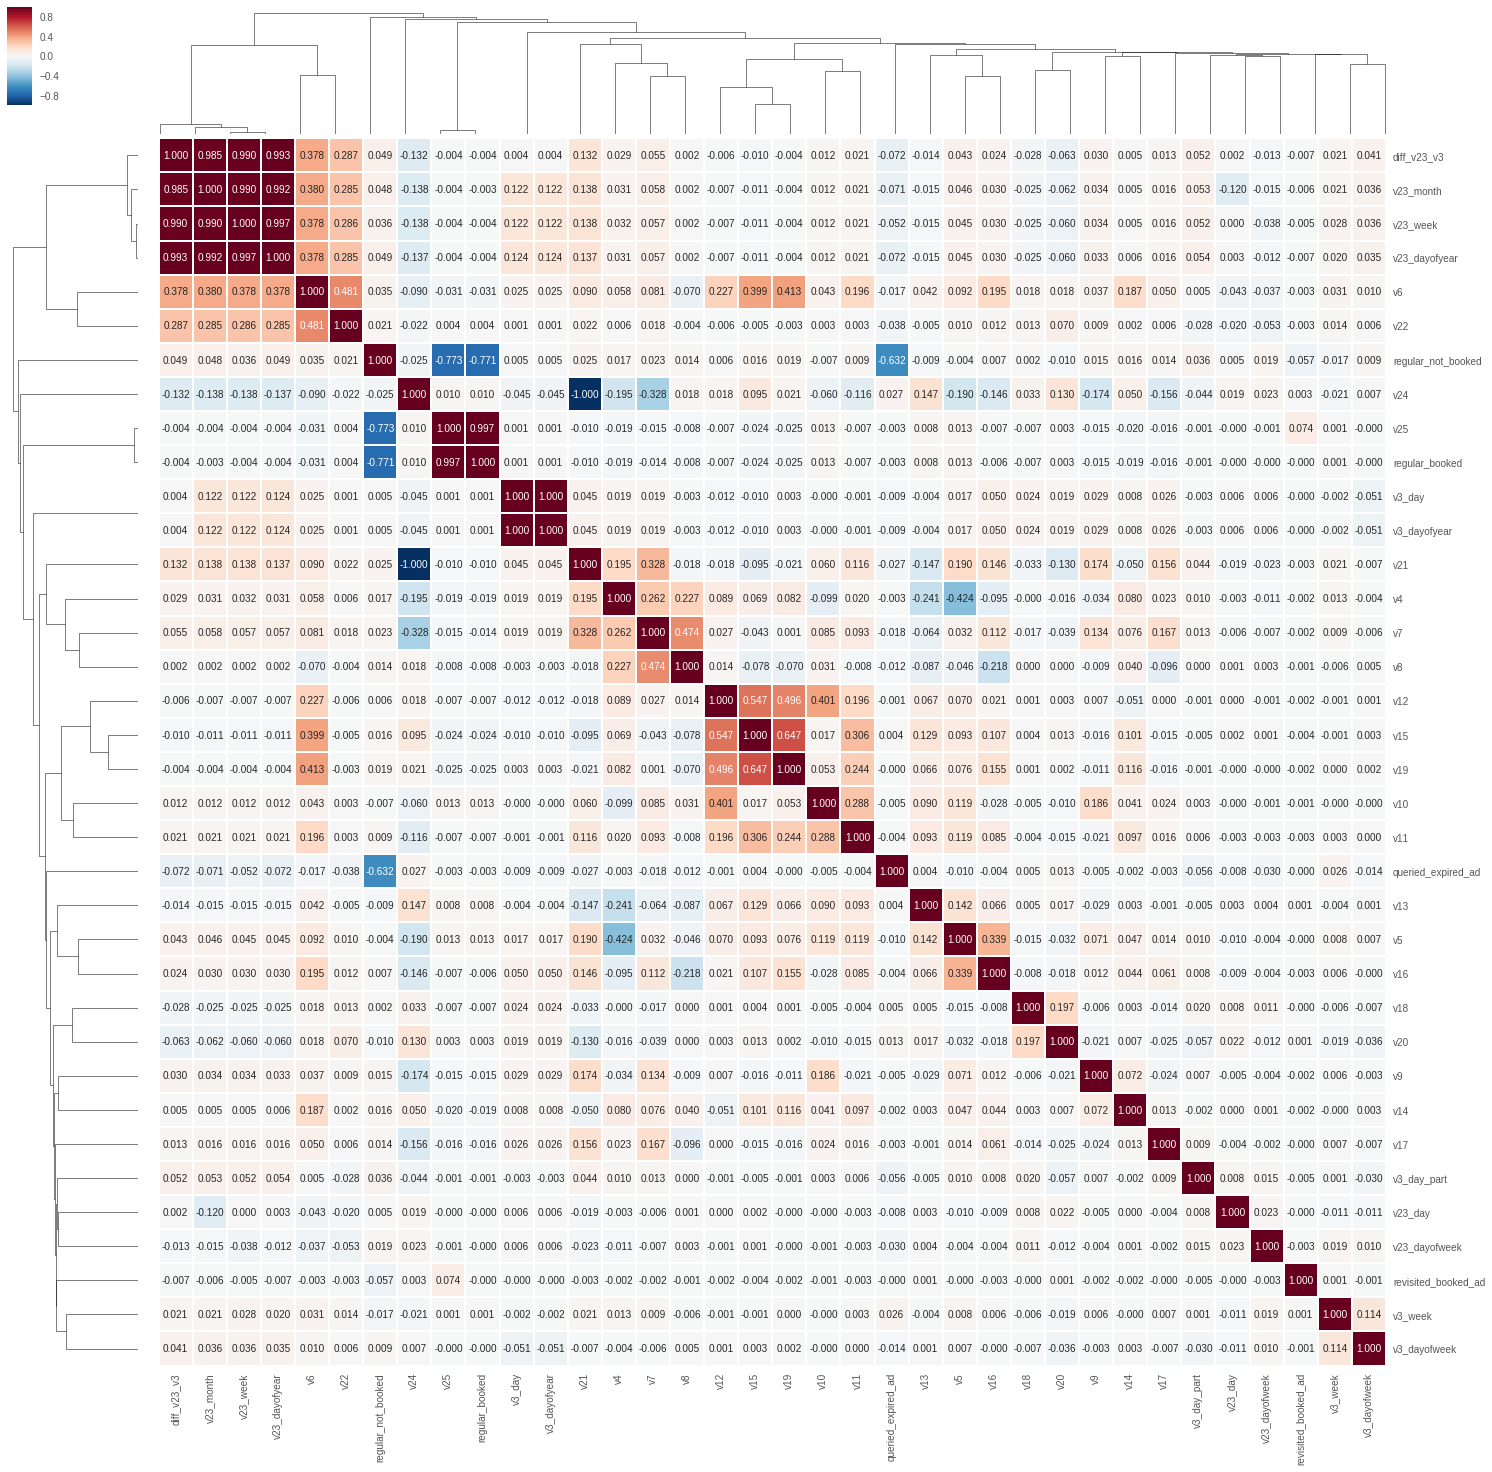

In [11]:
df_encoded = df_cleaned.apply(encode)
g = sns.clustermap(df_encoded.corr(), linewidths=1, square=True, annot=True, fmt=".3f", figsize = (25, 25))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0); 

### Plot Distributions of Some Knowing Features According to Specific Time Period

In this step, we investigate tendency of customer with respect to two different times, such querying time, booked time.
In those different time period, customers have mostly different tendency.

In [276]:
def plot_percentage(by, df):
    df_selected = df[[by, 'v6', 'regular_booked', 'v22']][df_cleaned['regular_booked'] == 1]

    figure, axes = plt.subplots(1, 3, figsize=(30,5))

    a = df_selected.groupby(by)['v6'].mean() 
    b = a.sum()
    p = (a/b)
    ax = sns.barplot(x=p.index, y = p.values, ax = axes[0])
    ax.set_ylabel('v6 (mean %)')

    a = df_selected.groupby(by)['regular_booked'].sum() 
    b = a.sum()
    p = (a/b)
    ax = sns.barplot(x=p.index, y = p.values, ax = axes[1])
    ax.set_ylabel('regular_booked (sum %)')

    a = df_selected.groupby(by)['v22'].mean() 
    b = a.sum()
    p = (a/b)
    ax = sns.barplot(x=p.index, y = p.values, ax = axes[2])
    ax.set_ylabel('v22 (mean %)')

## Exposing Customer Behaviour in Quering and Booking a Car
0: Early Morning, 1: Morning, 2: Afternoon, 3: Evening

** According to day part plots at 1st row**
* Customers mostly are booking a car in afternoon. It is roughly 45% of all booked car as we see in regular_booked graph.
* Customers rarely are booking a car in early morning. It is less 2% of all booked car as we see in regular_booked graph.
* Customers mostly are prefering a car in terms of high average rental duration when they are booking in early morning as we see in v22 graph at 1st row 3rd column.
* Customers mostly are paying more average money when they are booking in early morning as we see in v6 graph because they prefers long rental duration instead of short rental when they book a car in early morning.
* They prefer mostly modarate price and rental duration when they book a car in afternoon.

** According to week plots at 2nd row **
* Customers never don't book any car after week 5th up to week 52nd.
* The number of booking is going down up to week 52nd.
* The most average booking is done in week 3rd by customers.
* The highest average rental duration is being prefering in week 52th when they book a car.
* The average prices they prefer are modarate each week except for between 6-51 weeks.
* Although the most lowest bookig car is being done in week 52th by customers, they also are prefering long rental duration.

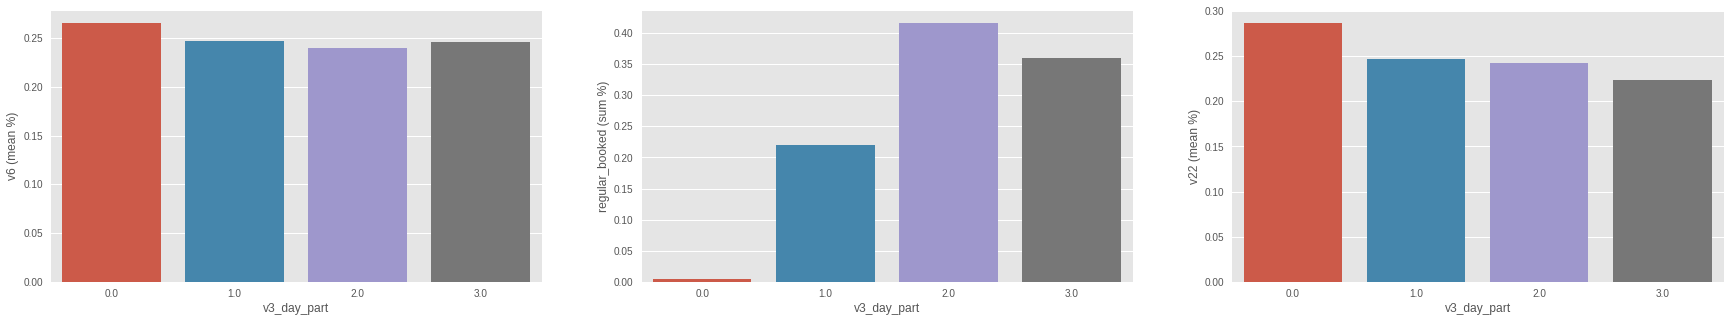

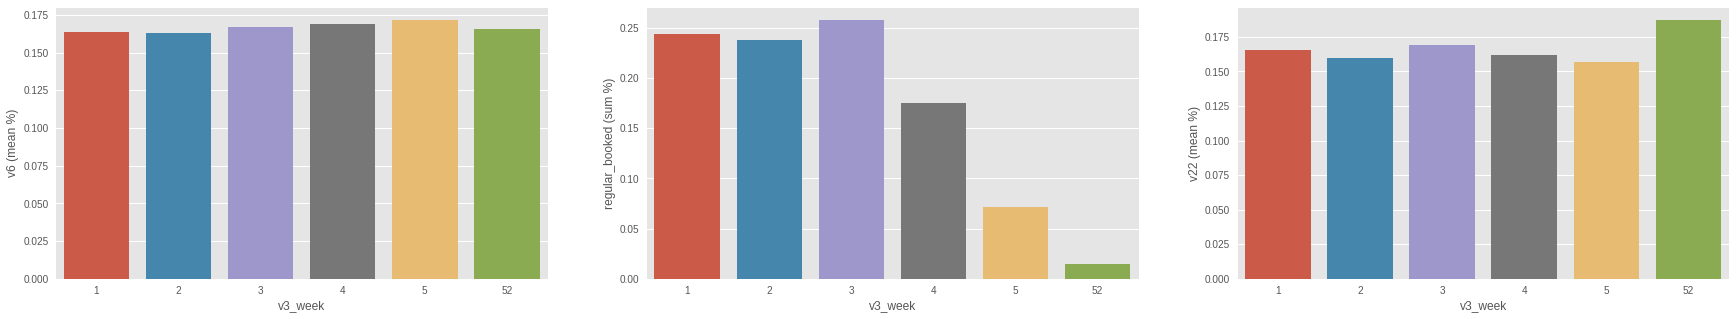

In [287]:
plot_percentage('v3_day_part', df_cleaned)
plot_percentage('v3_week', df_cleaned)

## Exposing Customer Booking Preferences Over Booked Car

** According to month part plots in 1st row **
* The the number of average booked car monthly is going down up to December as we see in regular_booked graph.
* However, There is no booked car in November.
* The the highest number of average booked car with low average price and modarate average rental duration is being done in February by customer.
* The the lowest number of average booked car with moderate average price and high average rental duration is being done in December by customer. Probably, customers may have new-year and Christmas vacation so they prefer a long rental duration.
* The average price of car and rental duration are mostly high around summer time between May and October although the number of average booked car is going down. Probably, customers may have a vacation in summer so they prefer a long rental duration to short one.

** According to week plots in 2nd row **
* In weekly plot, we can see more details about customers' preferences.
* However, There is no booked car in week 44th-47th, 49th-50th and week 52th.
* The the highest number of average booked car with low average price and modarate average rental duration is being done in week 6th (February 6, 2017	February 12, 2017) by customer.
* The the lowest number of average booked car with moderate average price and high average rental duration is being done in week 51st (December 18, 2017 - December 24, 2017) by customer. Probably, customers may have new-year and Christmas vacation so they prefer a long rental duration.
* To explain that preferences well, We need to take look at a few next week after week 51st.

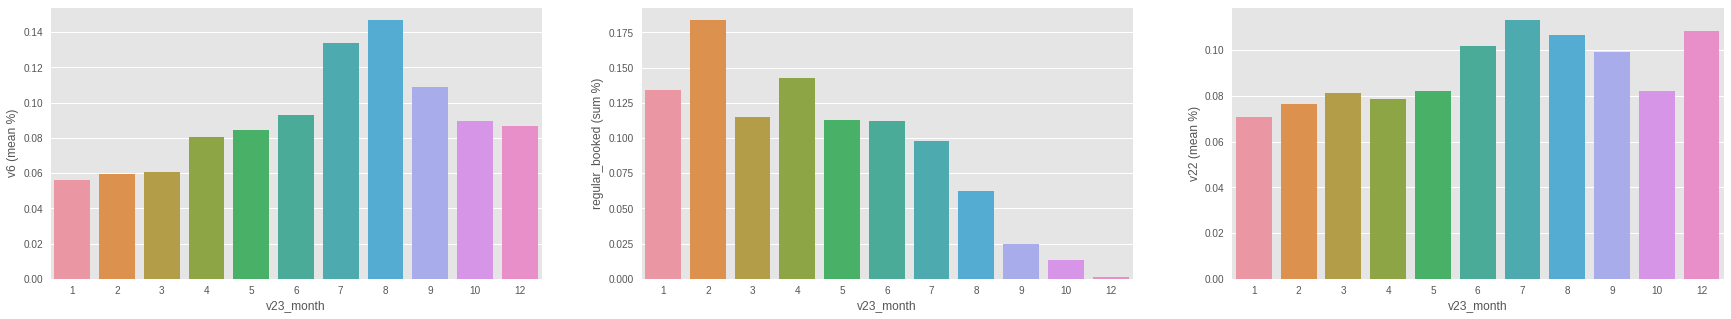

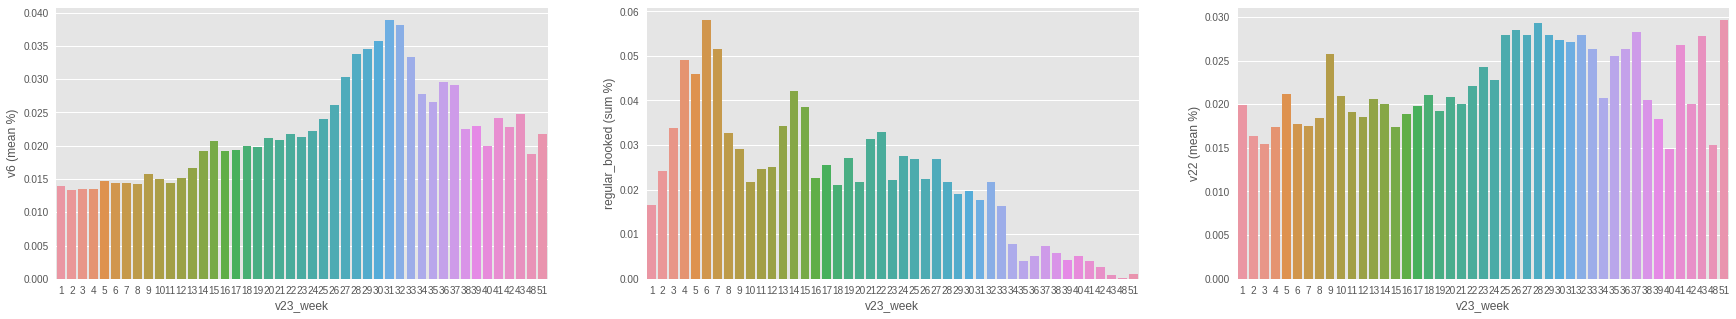

In [279]:
plot_percentage('v23_month', df_cleaned)
plot_percentage('v23_week', df_cleaned)

## Exposing Customer Booking Preferences by Using CDF (Cumulative Distribution Function) over Specific Features (diff_v23_v3, v6, v22)

As we discused before, when we were creating a new feature related to the timestamps (querying date and pickup date), diff_v23_v3 is difference (D) between the both specific date which means that a car is being booked in prior to D days by customer.

Since the other two specific features' name already know, we also used them. Actually, we can use the rest continuous variables however, we cannot make meaningful comment about customer.

To expose valuable insight well, we used CDF in this step.

In [292]:
def plot_cdf(p, 
             ax, 
             deltax=None, 
             xlog=False, 
             xlim=[0, 1], 
             deltay=0.25, 
             ylog=False, 
             ylim=[0,1], 
             xlabel = 'x'):
    
    ecdf = sm.distributions.ECDF(p)
    x = ecdf.x
    y = ecdf.y
    assert len(x) == len(y)
    if deltax is not None:
        x_ticks = np.arange(xlim[0], xlim[1] + deltax, deltax)
        ax.set_xticks(x_ticks)
    
    ax.set_xlabel(xlabel)
    ax.set_xlim(xlim[0], xlim[1])
    ax.vlines(np.mean(p), min(y), max(y), color='red', label='mean', linewidth=2)
    ax.vlines(np.median(p), min(y), max(y), color='orange', label='median', linewidth=2)
    ax.vlines(np.mean(p) + 2 * np.std(p), min(y), max(y), color='blue', label='mean + 2 * std', linewidth=2)
    ax.vlines(np.mean(p) + 3 * np.std(p), min(y), max(y), color='green', label='mean + 3 * std', linewidth=2)

    y_ticks = np.arange(ylim[0], ylim[1] + deltay, deltay)
    ax.set_ylabel('CDF')
    ax.set_yticks(y_ticks)
    ax.set_ylim(ylim[0], ylim[1])

    if xlog is True:
        ax.set_xscale('log')

    if ylog is True:
        ax.set_yscale('log')
    
    
    ax.grid(which='minor', alpha=0.5)
    ax.grid(which='major', alpha=0.9)
    
    ax.legend(loc=4)
    
    sns.set_style('whitegrid')
    sns.regplot(x=x, y=y, fit_reg=False, scatter=True, ax = ax)
    
def plot_cdf_by_feature(by, df, deltax, booked_types = ['regular_not_booked', 'regular_booked']):
    cdf_by_1 = df[df[booked_types[1]] == True][by].values.tolist()

    figure, axes = plt.subplots(1, figsize=(15,5))

    plot_cdf(cdf_by_1, 
             axes, 
             deltax=deltax, 
             xlim=[0, np.mean(cdf_by_1) + 3 * np.std(cdf_by_1) + 50],
             deltay = 0.05,
             ylim=[0, 1.00], xlabel=by)

** CDF of diff_v23_v3 on 1st graph ** (Time Diff)
* Customers mostly are booking a car in prior to rougly 240 days and early. It means that 95% of the booked car were booked in prior to rougly 240 days and before. P(D <=240 days) = 0.95
* Or, 95% of the booked car were booked in prior to rougly at least 5 and lately.  P(D >= 5 days) ~= 0.95
* P(D >= 5 days and D <=240 days) ~= 0.90
* Median days costumer preferred is P(D <= 85 days) ~= 0.5

** CDF of v6  on 2nd graph ** (Price)
* I assumed that the unit of money is EUR.
* Customers mostly are booking a car which is cheaper than 690 EUR. It means that 95% of the price of booked car is cheaper than 960 EUR.  P(v6 <= 690 EUR) ~= 0.95
* Or, 95% of the price of booked car is more expensive than 175 EUR. P(v6 >= 175 EUR) ~= 0.95
* P(v6 >= 175 EUR and v6 <= 690 EUR) ~= 0.90
* Median price of car costumer preferred is P(v6 <= 280 EUR) ~= 0.5

** CDF of v22 on 3rd graph ** (Rental Duration)
* I assumed that the unit of  rental duration is day.
* Customers mostly are booking a car whose rental duration is less than 23 days. It means that 95% of the rental duration of booked car is less than 23days. P(v22 <= 23 days) ~= 0.95
* Or, 95% of the rental duration of booked car is higher than 3 days. P(v22 >= 3) ~= 0.95
* P(v22 >= 3 days and v22 <= 23 days) ~= 0.90
* Median price of car costumer preferred is P(v22 <= 6 days) ~= 0.5

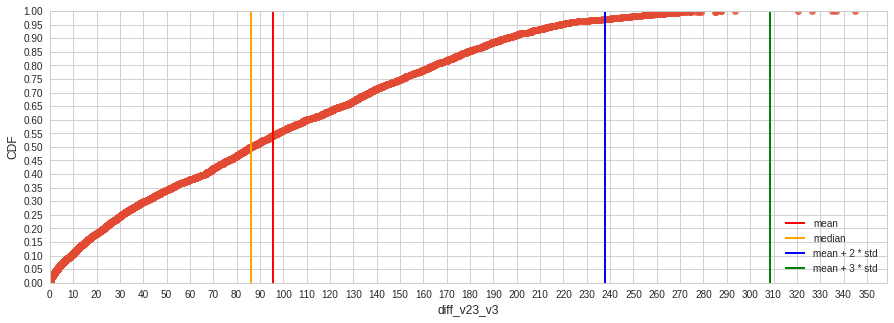

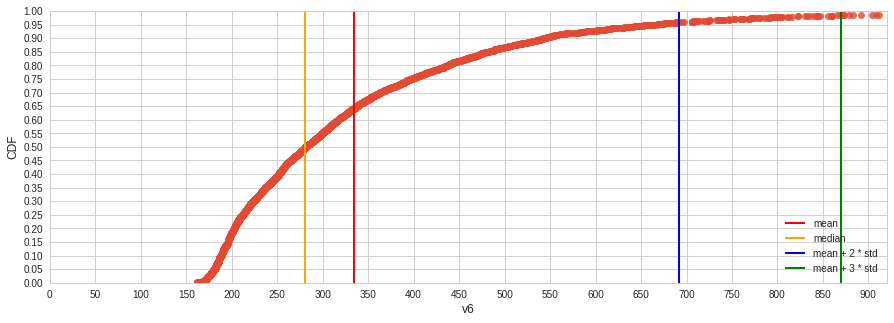

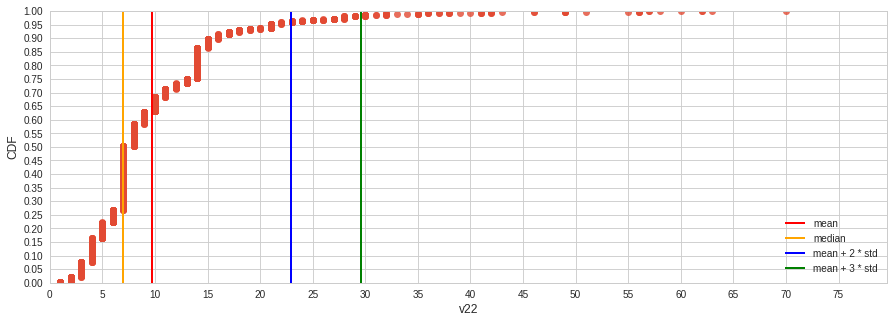

In [293]:
# CDF of time difference on original cleaned data 
plot_cdf_by_feature('diff_v23_v3', df_cleaned[['regular_not_booked', 'regular_booked', 'diff_v23_v3']], 10)

# CDF of price of car on original cleaned data 
plot_cdf_by_feature('v6', df_cleaned[['regular_not_booked', 'regular_booked', 'v6']], 50)

# CDF of rental duration on original cleaned data 
plot_cdf_by_feature('v22', df_cleaned[['regular_not_booked', 'regular_booked', 'v22']], 5)

## Boxplotting Time Difference, Price, Rental Duration

To expose the distribution of labaled features values (0 and 1), we plotted the boxplots of regular_booked and v25 by diff_v23_v3, v6, v22.

** According to regular_booked plots in 1st row **
* The shape of regular_booked by 0s and 1s is almost same. They have almost same median and ranges

** According to v5 plots in 2nd row **
* The shape of regular_booked by 0s and 1s is almost same. They have almost same median and ranges


According to the both type of plots, the labelled feature is mostlikely generated synthetically because there is just small shifting between 0s and 1s on all plots. However, the number of instance is not balanced as you can see in the next picture at the next step. So, that problem can be called as imbalaced data since laballed feature has skewness.

In [296]:
def plot_boxplot(by, df):
    figure, axes = plt.subplots(1, 3, figsize=(15,2))

    ax = sns.boxplot(x=by, y="diff_v23_v3", data=df[[by,  'diff_v23_v3']], ax = axes[0])
    ax.set_yscale('log')

    ax = sns.boxplot(x=by, y="v6", data=df[[by,  'v6']], ax = axes[1])
    ax.set_yscale('log')

    ax = sns.boxplot(x=by, y="v22", data=df[[by,  'v22']], ax = axes[2])
    ax.set_yscale('log')

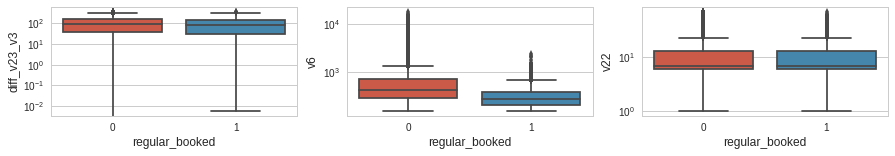

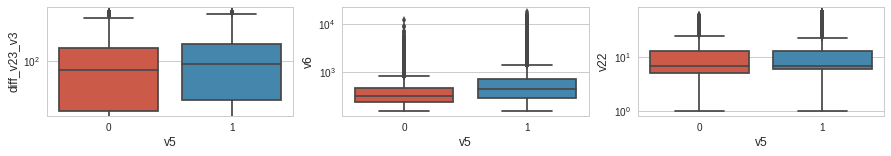

In [297]:
plot_boxplot('regular_booked', df_cleaned[['regular_booked', 'diff_v23_v3', 'v6', 'v22']])
plot_boxplot('v5', df_cleaned[['v5', 'diff_v23_v3', 'v6', 'v22']])

## Exploring Labeled Feature to Overcome Skewness

As we discussed in previous step, the labeled feature has shewness shape.

In the next, you can see the distrubation of the labels, below.

* 0s labeled feature is rougly than 99%. It is almost 100%.
* 1s labeled feature is rougly less than 1%

Before solve that problem, we applied a few technique to make sure everything, so far.

v25
0    0.996304
1    0.003696
Name: v25, dtype: float64

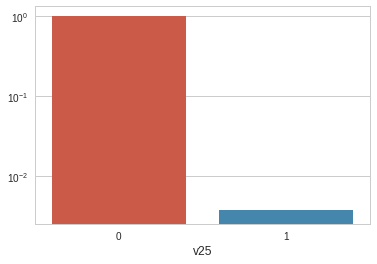

In [306]:
grouped_by_v25 = df_cleaned.groupby('v25')['v25']

p = grouped_by_v25.size() / len(df_cleaned)
sns.barplot(x=p.index, y=p.values, log=True)
display(p)

** We designed two different approach to process the data**
1. Approach#1 is sampling the original data to create a new small data which will be represent our original data. In this approach, the both of dataset (original and generated) has same ration in terms of labeled features
2. Approach#2 is applying for whole data with cross_validation

In [322]:
def create_train_test(df, by, sample_size):

    grouped = df.groupby(by)[by]
    
    frac = grouped.size().values / len(df)
    
    sample_sizes_by_class = sample_size * frac
    
    class_0_train = df[df[by] == 0].sample(int(sample_sizes_by_class[0]))
    class_0_test =  df[df[by] == 0].drop(class_0_train.index)

    class_1_train = df[df[by] == 1].sample(int(sample_sizes_by_class[1]))
    class_1_test =  df[df[by] == 1].drop(class_1_train.index)

    df_train = class_0_train.append(class_1_train , ignore_index=True)
    df_test = class_0_test.append(class_1_test, ignore_index=True)
    
    X_train = df_train.drop(by, 1).values.tolist()
    y_train = df_train[by].values.tolist()

    X_test = df_test.drop(by, 1).values.tolist()
    y_test = df_test[by].values.tolist()
    
    return X_train, y_train, X_test, y_test

def report_classification(clf, X_train, y_train, X_test, y_test, target_names = ['not_booked', 'booked']):
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)
    
    figure, axes = plt.subplots(1, 2, figsize=(10,5))

    cm_test = confusion_matrix(y_test, y_test_pred)
    df_cm_test = pd.DataFrame(cm_test, index = target_names, columns = target_names)
    ax = sns.heatmap(df_cm_test, annot=True, ax = axes[0], square= True)
    ax.set_title('Test CM')

    cm_train = confusion_matrix(y_train, y_train_pred)
    df_cm_train = pd.DataFrame(cm_train, index = target_names, columns = target_names)
    ax = sns.heatmap(df_cm_train, annot=True, ax = axes[1], square= True)
    ax.set_title('Train CM')

    print('-' * 20 + 'Testing Performance' + '-' * 20)
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print('acc: ', metrics.accuracy_score(y_test, y_test_pred))

    print('-' * 20 + 'Training Performance' + '-' * 20)
    print(classification_report(y_train, y_train_pred, target_names=target_names))
    print('acc: ', metrics.accuracy_score(y_train, y_train_pred))


def apply_cross_val(clf, X_train, y_train):
    val_scores = cross_val_score(clf, X_train, y_train, cv = 10, verbose= 1)
    print("Cross Validation Scores: ", val_scores)
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (val_scores.mean(), val_scores.std() * 2))
    

def plot_importances(clf, df, target_label='v25'):

    df_imp = pd.DataFrame(index=df.drop([target_label], 1).columns.tolist(), 
                          data=clf.feature_importances_, columns=['importance'])
    df_imp.sort_values(by='importance', ascending=False, inplace=True)
    print('Most importance features ordered by importance')
    print(df_imp.index.tolist())
                    
    figure, axes = plt.subplots(1, figsize=(15,8))
    ax = sns.barplot(x = df_imp.importance, y = df_imp.index, ax=axes)
    ax.set_xscale('log')
    plt.grid(True, which="both")
    
def approach_1(clf, df, cross_val = False, target_label='v25', sample_size=1000):    
    X_train, y_train, X_test, y_test = create_train_test(df, target_label, sample_size)
    
    if cross_val:
        apply_cross_val(clf, X_train, y_train)
       
    clf = clf.fit(X_train, y_train)

    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)
    
    report_classification(clf, X_train, y_train, X_test, y_test)
    plot_importances(clf, df, target_label)

def approach_2(clf, df, cross_val = False, target_label='v25'):
    X_train = df_cleaned.drop(target_label, 1).values.tolist()
    y_train = df_cleaned[target_label].values.tolist()
    apply_cross_val(clf, X_train, y_train)
    
clf = RandomForestClassifier(n_jobs=-1, n_estimators=10)

** As we disscussed before, we got rid of high correlated features with v25. Those are 'regular_booked', 'regular_not_booked'. **
* After that cleansing, we took a sample dataset which consists of 1000 different instances and then applied Random Forest classifier.
* As we see the result of ML algorithm for approach1 and approach2, we have overfitting problem becuase the label featuare has skewness.
* Under these circumstances, actually, we don't need to build a ML because the most labels consist of 0s (99%). So, if we don't want to build a ML model, we can label whole new incoming instances as 0.
* Therefore, we need to solve that problem using some special sampling technique to overcome skewness data.

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished


Cross Validation Scores:  [ 0.99009901  0.99009901  0.99009901  1.          1.          1.          1.
  1.          1.          1.        ]
Cross Validation Accuracy: 1.00 (+/- 0.01)
--------------------Testing Performance--------------------
             precision    recall  f1-score   support

 not_booked       1.00      1.00      1.00   1067957
     booked       0.04      0.00      0.00      3963

avg / total       0.99      1.00      0.99   1071920

acc:  0.996278640197
--------------------Training Performance--------------------
             precision    recall  f1-score   support

 not_booked       1.00      1.00      1.00       996
     booked       1.00      1.00      1.00         3

avg / total       1.00      1.00      1.00       999

acc:  1.0


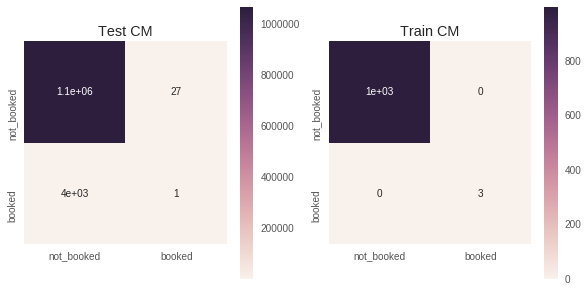

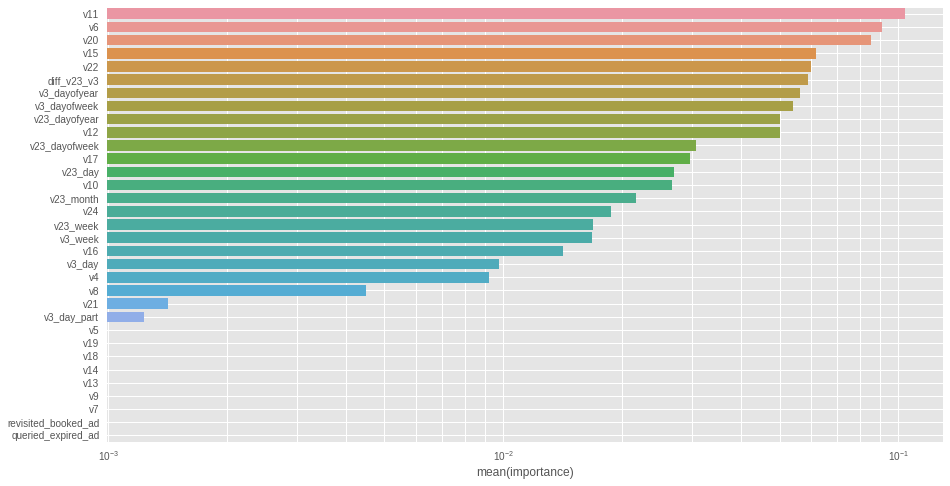

In [216]:
df = df_cleaned.drop(['regular_booked', 'regular_not_booked'], 1)
approach_1(clf, df, True, sample_size=1000)

In [66]:
df = df_cleaned.drop(['regular_booked', 'regular_not_booked'], 1)
approach_2(clf, df)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   35.7s finished


Cross Validation Scores:  [ 1.          1.          1.          0.99999068  1.          1.          1.
  0.99999068  0.99999068  1.        ]
Cross Validation Accuracy: 1.00 (+/- 0.00)


### Overcoming Imbalanced Data (Skewness) Problem
There are a few sampling techniques to overcome that problem, below
* Oversampling
* Undersampling
* SMOTE
* ADASYN

We used oversampling and SMOTE. However, we decided to use oversampling technique at the end of day since it is faster than SMOTE (based on SVM) in terms of performance issue based on hardware computing and time.

* We increased the ration of minority up to 0.7% instead of creating equal ratio classes.
* After solving imbalanced data issue, we applied same approaches again in the next steps.

In [308]:
# from imblearn.over_sampling import SMOTE
# kind = ['regular', 'borderline1', 'borderline2', 'svm']
# ros = SMOTE(kind=kind[3])

df = df_cleaned.drop(['regular_booked', 'regular_not_booked'], 1)
X = df.drop('v25', 1)
y = df['v25']

ros = RandomOverSampler(0.7)
X_resampled, y_resampled = ros.fit_sample(X, y)

df_oversampled = pd.DataFrame(list(map(lambda x: tuple(x), X_resampled)), columns= X.columns)
df_oversampled['v25'] = y_resampled

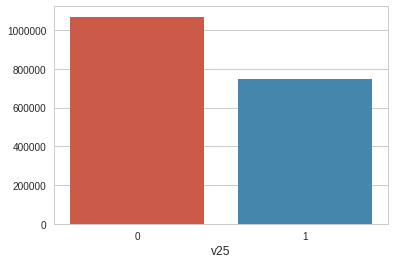

In [312]:
grouped_by_v25 = df_oversampled.groupby('v25')['v25']
sns.barplot(x=grouped_by_v25.size().index, y=grouped_by_v25.size().values)

* Take a look at the correlation again after oversampling

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


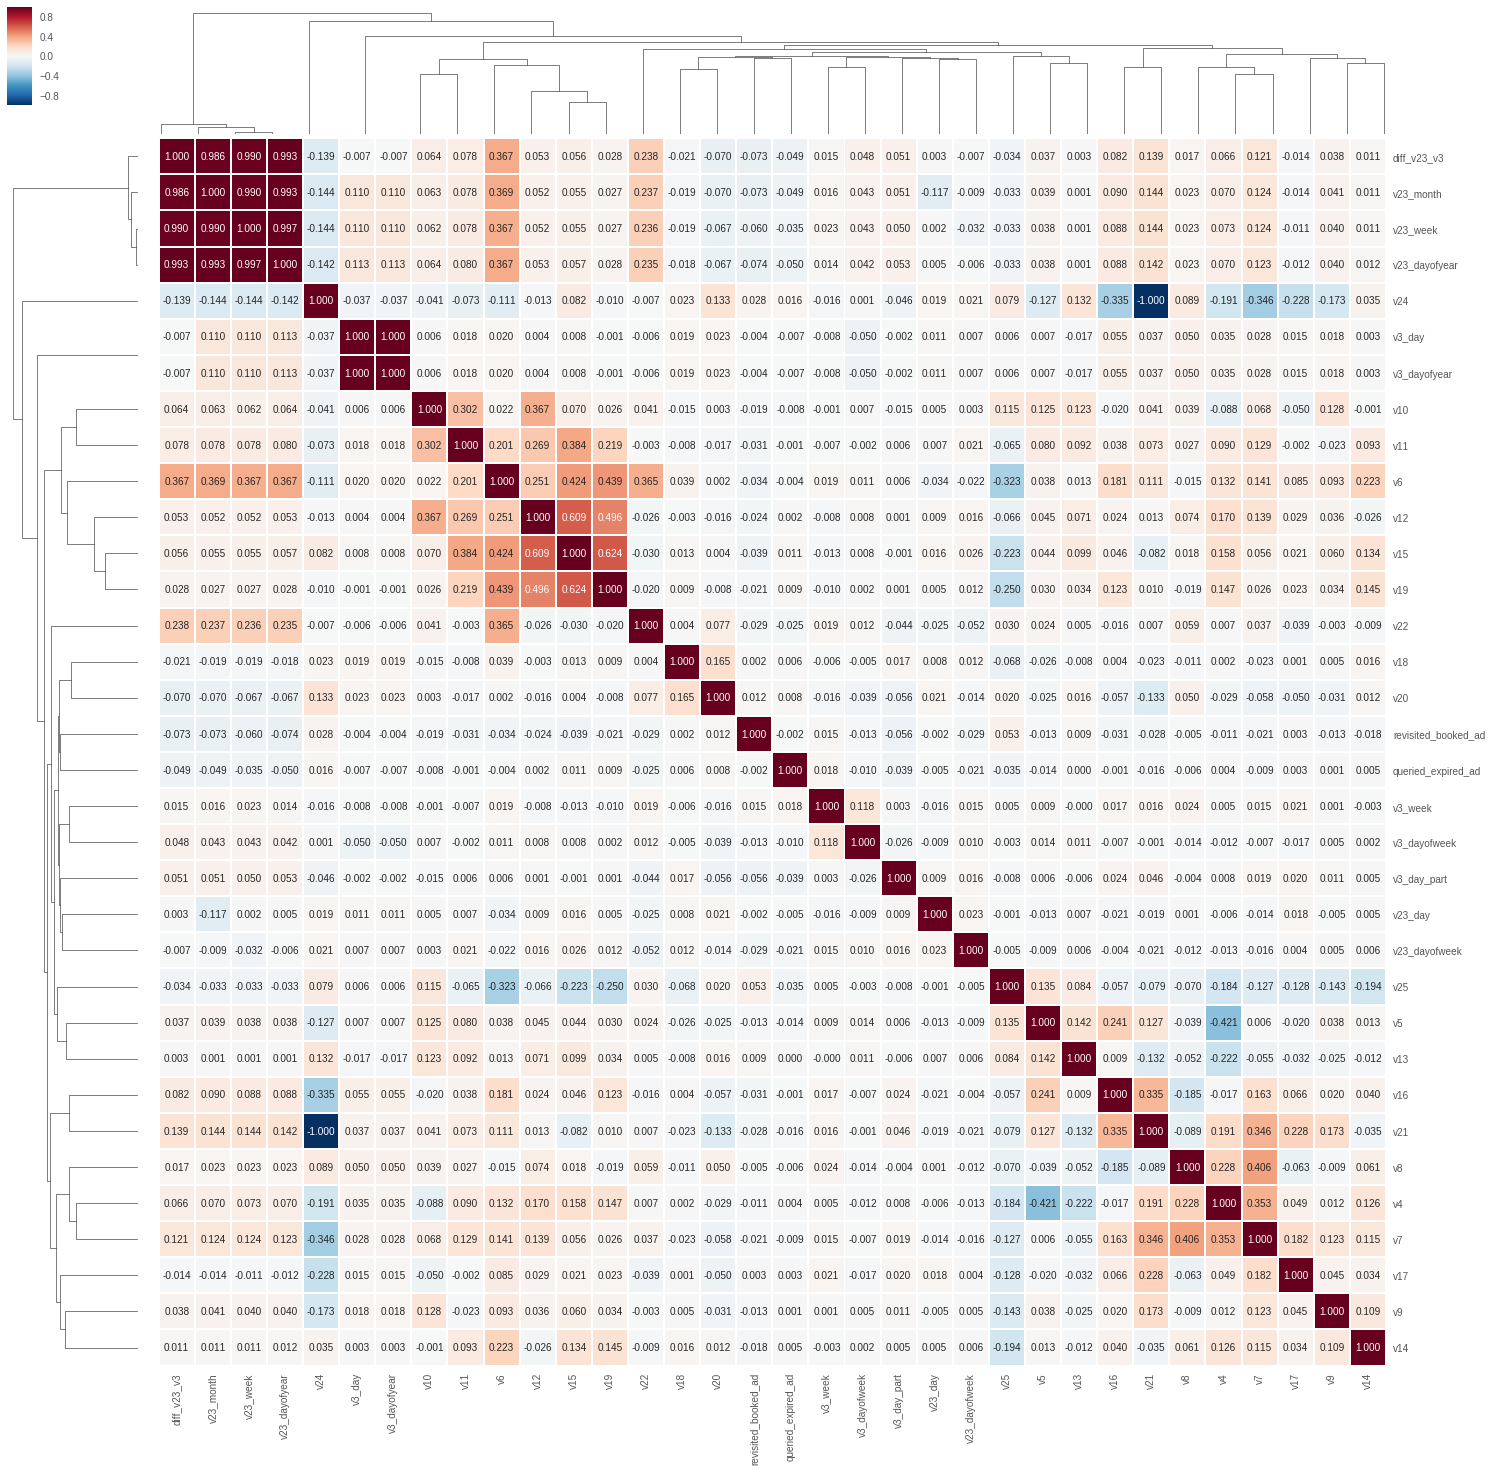

In [57]:
df_encoded = df_oversampled.apply(encode)
g = sns.clustermap(df_encoded.corr(), linewidths=1, square=True, annot=True, fmt=".3f", figsize = (25, 25))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0); 

## Final Results and Conclusion
* According to cross_validation results of apporch#2 in the next step, it will not reasonable approach to use whole data in cross_validation with respect to 10 Kfold. Becuase, it is overfitting although we applied oversampling.
* Sometimes oversampling is causing an overfitting problem. However, this dataset has skewness in its nature.
* It is giving a resonable result in small sample dataset which represents totaly original data.
    * The performance of approach#1 is better than performance of approch#2.
    * Even if we use a small sampling dataset (10000) after making oversamping, the metrics precision and recall have really reasonable results on the rest of data (1807221).
* According to feature importance on Rando Forest classifier, we can make a comment about their contribution on labeled features
    * v6 (price of car) has most importance. it means that it is playing important role to build a tree. So, we can think that that feature have the highest influence on booking a car.
    * the most lowest importances belong to the new feature we extracted from v25 and time difference. We can think that those features and similars are useless features because they don't have highe influence on booking a car.
    
* You can find the importance of features ordered by contribution respectively, here:
    1. 'v6'
    2. 'v17'
    3. 'v22'
    4. 'diff_v23_v3'
    5. 'v23_dayofyear'
    6. 'v23_week'
    7. 'v23_day'
    8. 'v15'
    9. 'v16'
    10. 'v3_dayofyear'
    11. 'v7'
    12. 'v3_day'
    13. 'v9'
    14. 'v23_dayofweek'
    15. 'v11'
    16. 'v3_dayofweek'
    17. 'v10'
    18. 'v23_month'
    19. 'v3_week'
    20. 'v20'
    21. 'v3_day_part'
    22. 'v19'
    23. 'v8'
    24. 'v14'
    25. 'v12'
    26. 'v4'
    27. 'v24'
    28. 'v21'
    29. 'v5'
    30. 'v18'
    31. 'v13'
    32. 'revisited_booked_ad'
    33. 'queried_expired_ad'



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.3s finished


Cross Validation Scores:  [ 0.88011988  0.88411588  0.856       0.875       0.857       0.864       0.875
  0.89489489  0.88188188  0.88288288]
Cross Validation Accuracy: 0.88 (+/- 0.02)
--------------------Testing Performance--------------------
             precision    recall  f1-score   support

 not_booked       0.89      0.91      0.90   1063071
     booked       0.86      0.84      0.85    744150

avg / total       0.88      0.88      0.88   1807221

acc:  0.88050160993
--------------------Training Performance--------------------
             precision    recall  f1-score   support

 not_booked       0.99      1.00      1.00      5882
     booked       1.00      0.99      0.99      4117

avg / total       0.99      0.99      0.99      9999

acc:  0.994299429943
Most importance features ordered by importance
['v6', 'v17', 'v22', 'diff_v23_v3', 'v23_dayofyear', 'v23_week', 'v23_day', 'v15', 'v16', 'v3_dayofyear', 'v7', 'v3_day', 'v9', 'v23_dayofweek', 'v11', 'v3_dayofweek', 'v10',

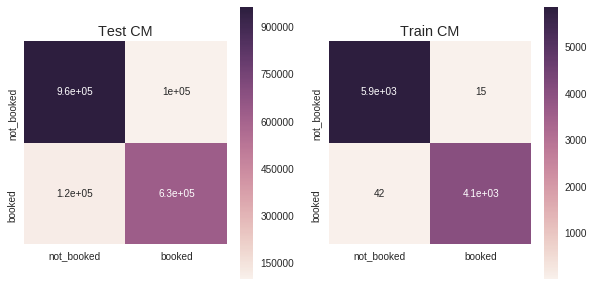

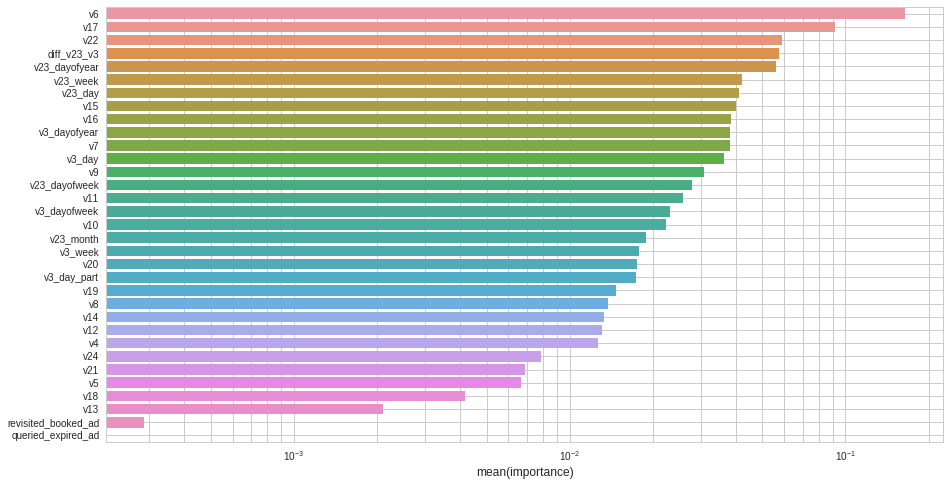

In [323]:
approach_1(clf, df_oversampled, True, sample_size=10000)

In [144]:
clf = RandomForestClassifier(n_jobs=-1, n_estimators=10, max_depth=5, criterion='entropy')
approach_2(clf, df_oversampled)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   32.4s finished


Cross Validation Scores:  [ 0.99968311  0.99997204  0.99943146  1.          0.99988816  0.99998136
  0.99998136  0.99993476  0.99996272  0.99998136]
Cross Validation Accuracy: 1.00 (+/- 0.00)
